In [2]:
import json
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch_geometric.utils import to_dense_batch
import torch.optim as optim
import json

sys.path.append(os.path.abspath(".."))
from functions.utils_L2D import load_and_restore_parquet, display_frames

## Phase 1: Generating the Graphs

#### 1. Download Data

- To download only one episode, use data_downloader(ep_num,...)

- To download a range of episodes, use data_downloader(min_ep,max_ep,...)

- Additionally, you can chnge the following directories:

    - tabular_data_dir = '../data/raw/L2D/tabular'

    - frames_dir = '../data/raw/L2D/frames'

In [3]:
from functions.load_data_L2D import data_downloader

data_downloader(32,n_secs=3,
                features={"tabular": True,
                          "frames": {
                                'observation.images.front_left': True,
                                'observation.images.left_backward': False,
                                'observation.images.left_forward': False,
                                'observation.images.map': False,
                                'observation.images.rear': False,
                                'observation.images.right_backward': False,
                                'observation.images.right_forward': False,
                            }
                        })

[av1 @ 0xaa3bd00] Your platform doesn't suppport hardware accelerated AV1 decoding.
[av1 @ 0xaa3bd00] Failed to get pixel format.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xaa3bd00] Missing Sequence Header.
[av1 @ 0xa

In [4]:
df = load_and_restore_parquet('../data/raw/L2D/tabular/episode_000032.parquet')
df.head()

,observation.state.vehicle,observation.state.waypoints,observation.state.timestamp,task.policy,task.instructions,action.continuous,action.discrete,timestamp,frame_index,episode_index,index,task_index
0,"[28.851562, 43.10965, 0.57818, 51.78767, 6.129...","[[6.129905, 51.78773], [6.130005, 51.7878], [6...",1724930626022292165,EXPERT,"At the next right turn coming up, turn right i...","[0.027559055, 0.0, -0.016041668]","[3, 2]",0.0,0,32,9971,0
1,"[17.84375, 39.822693, 0.96858, 51.787807, 6.13...","[[6.130089, 51.787872], [6.130186, 51.787933],...",1724930629023321302,EXPERT,"At the next right turn coming up, turn right i...","[0.0, 0.14634146, -0.00083333335]","[3, 2]",3.0,30,32,10001,0
2,"[15.234375, 58.068726, 1.21599, 51.78789, 6.13...","[[6.130186, 51.787933], [6.130324, 51.787937],...",1724930632024396972,EXPERT,"At the next right turn coming up, turn right i...","[0.098425195, 0.0, 0.34604168]","[3, 2]",6.0,60,32,10031,0
3,"[21.367188, 89.08917, 0.85741, 51.78791, 6.130...","[[6.130468, 51.78793], [6.130612, 51.787933], ...",1724930635025387272,EXPERT,"At the next right turn coming up, turn right i...","[0.1496063, 0.0, -0.008125001]","[3, 0]",9.0,90,32,10061,0
4,"[26.15625, 84.18417, 0.76451, 51.787918, 6.130...","[[6.130757, 51.78794], [6.130902, 51.787945], ...",1724930638026407226,EXPERT,"At the next right turn coming up, turn right i...","[0.047244094, 0.0, -0.008541667]","[3, 0]",12.0,120,32,10091,0


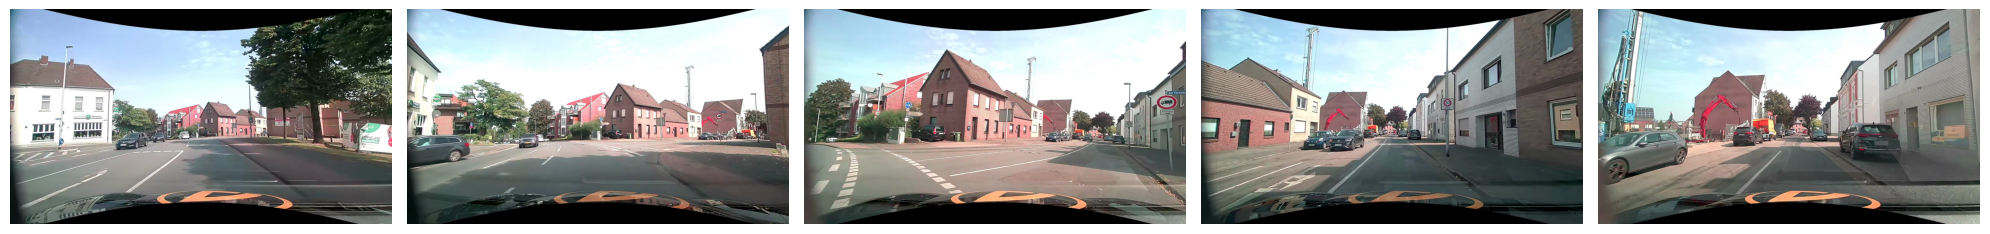

In [5]:
display_frames('../data/raw/L2D/frames/Episode000032/observation.images.front_left')

#### 2. Process Tabular Data & Add Tags

- To process only one episode, use process_tabular_data(ep_num,...)

- To process a range of episodes, use process_tabular_data(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - process_tabular_data:

        - source_dir = '../data/raw/L2D/tabular'

        - output_dir_processed = '../data/processed_data/L2D'

        - output_dir_tags = '../data/semantic_tags/L2D'

    - add_data_tags:

        - data_dir = '../data/processed/L2D'

        - tags_dir='../data/semantic_tags/L2D'

In [6]:
from functions.process_tabular_data_L2D import process_tabular_data
from functions.process_tags_L2D import add_data_tags

process_tabular_data(32,
                    overwrite=False, process_columns=True, 
                    process_osm=True, process_turning=True)
add_data_tags(32)

100%|██████████| 1/1 [00:00<00:00, 52.44it/s]


In [7]:
df = load_and_restore_parquet('../data/processed/L2D/episode_000032.parquet')
df.head()

,vehicle_speed,vehicle_heading,vehicle_heading_error,vehicle_latitude,vehicle_longitude,vehicle_altitude,vehicle_acceleration_x,vehicle_acceleration_y,waypoints,action_gas_pedal,...,bicycle,bridge,tunnel,traffic_controls,traffic_features,landuse,is_narrow,is_unlit,bike_friendly,turning_behavior
0,28.851562,43.109650,0.57818,51.787670,6.129874,51.787670,0.38,-0.29,"[{'x': 6.1299052238464355, 'y': 51.78773117065...",0.027559,...,None,no,no,None,None,residential,None,False,False,straight
1,17.843750,39.822693,0.96858,51.787807,6.130071,51.787807,-0.08,-1.20,"[{'x': 6.130088806152344, 'y': 51.787872314453...",0.000000,...,no,no,no,None,pedestrian_crossing,residential,None,False,False,straight
2,15.234375,58.068726,1.21599,51.787891,6.130204,51.787891,-2.05,-0.59,"[{'x': 6.130186080932617, 'y': 51.787933349609...",0.098425,...,no,no,no,None,pedestrian_crossing,residential,None,False,False,turning right
3,21.367188,89.089172,0.85741,51.787910,6.130410,51.787910,-0.16,0.74,"[{'x': 6.130467891693115, 'y': 51.787929534912...",0.149606,...,no,no,no,None,pedestrian_crossing,residential,None,False,False,straight
4,26.156250,84.184174,0.76451,51.787918,6.130705,51.787918,-0.07,0.00,"[{'x': 6.130756855010986, 'y': 51.787940979003...",0.047244,...,None,no,no,None,pedestrian_crossing,residential,None,False,False,straight


In [8]:
df['waypoints'][0]

[{'x': 6.1299052238464355, 'y': 51.7877311706543},
 {'x': 6.1300048828125, 'y': 51.78779983520508},
 {'x': 6.130088806152344, 'y': 51.787872314453125},
 {'x': 6.130186080932617, 'y': 51.787933349609375},
 {'x': 6.130323886871338, 'y': 51.78793716430664},
 {'x': 6.130467891693115, 'y': 51.78792953491211},
 {'x': 6.130611896514893, 'y': 51.787933349609375},
 {'x': 6.130756855010986, 'y': 51.787940979003906},
 {'x': 6.13090181350708, 'y': 51.78794479370117},
 {'x': 6.131045818328857, 'y': 51.7879524230957}]

In [9]:
with open('../data/semantic_tags/L2D/episode_000032.json', 'r') as f:
    tags = json.load(f)
tags

{'policy': 'EXPERT',
 'instructions': 'At the next right turn coming up, turn right into the 30 kph zone',
 'action_tag': 'right_turn',
 'traffic_control_tag': 'unmarked',
 'road_feature_tags': ['pedestrian_area', 'urban'],
 'environment_tags': ['off_peak_hours']}

#### 3. Process Frames

- Set up with depth model with pip install git+https://github.com/apple/ml-depth-pro.git

- To process only one episode, use process_frames(ep_num,...)

- To process a range of episodes, use process_frames(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - input_base_dir = '../data/raw/L2D/frames',
    
    - output_base_dir = '../data/processed_frames/L2D'

- You can also include the following cameras:

    - "observation.images.front_left",
    - "observation.images.left_forward", 
    - "observation.images.right_forward",
    - "observation.images.right_backward",
    - "observation.images.rear",
    - "observation.images.left_backward"

**Note**: Including additional cameras will help with the depth, speed, etc. but CONSIDERABLY increases running time.

In [10]:
from functions.process_frames_L2D import process_frames

process_frames(32,
               cameras_on=["observation.images.front_left"],
               run_dict={"detection": True,
                         "depth": True,
                         "speed": True,
                         'overwrite': True},
                verbose=True)


=== Setting up DepthPro ===
✅ Model downloaded successfully to: ml-depth-pro/checkpoints/depth_pro.pt


For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.


✅ Depth Pro available
PyTorch: 2.8.0+cu128
CUDA available: True
✅ Depth Pro model found
🔍 Initializing Depth Pro...
✅ Depth Pro model already exists
✅ Depth Pro loaded on cuda

=== Initializing RF-DETR Model ===
🤖 Initializing RF-DETR model...
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✅ RF-DETR model loaded successfully



🔹 Processing episode 32 with config: {'detection': True, 'depth': True, 'speed': True, 'overwrite': True}
  📷 Camera front_left: 5 frames found
  ✅ Processed 5 frames for front_left
✅ Finished Episode 32


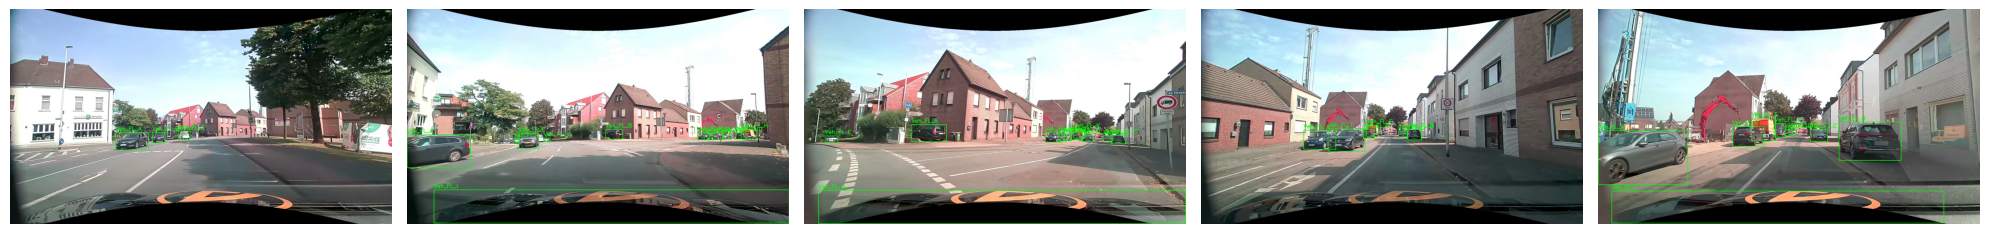

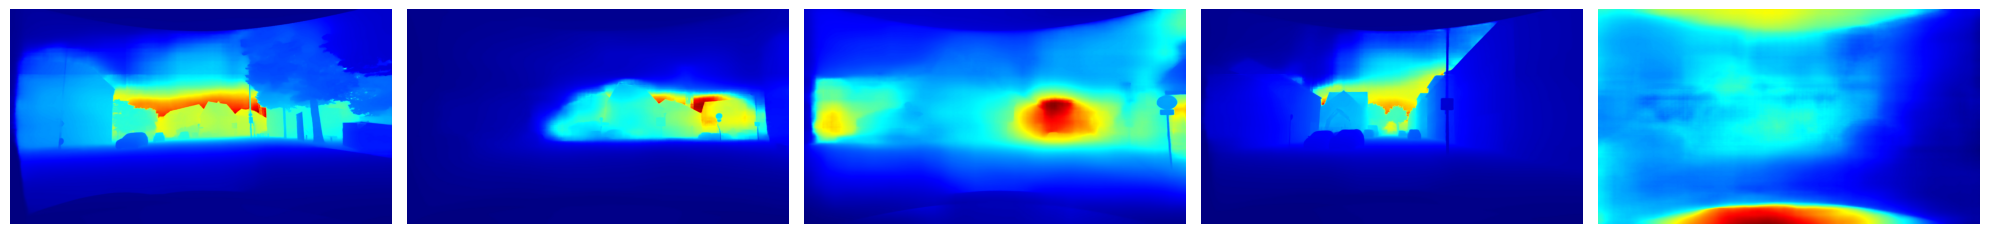

In [11]:
display_frames('../data/processed_frames/L2D/Episode000032/front_left_Segmented')
display_frames('../data/processed_frames/L2D/Episode000032/front_left_DepthColormaps')

In [12]:
# NEW
with open('../data/processed_frames/L2D/Episode000032/front_left_Annotations/frame_00001.json', 'r') as f:
    annotations = json.load(f)
annotations

{'info': {'description': 'L2D Dataset Detection Results',
  'date_created': '2025-08-12 06:44:46'},
 'images': [{'id': 1,
   'file_name': 'frame_00001.jpg',
   'width': 1920,
   'height': 1080,
   'camera': 'front_left',
   'has_depth': True}],
 'annotations': [{'id': 1,
   'image_id': 1,
   'category_id': 1,
   'track_id': 'Veh_FL_A',
   'bbox': [0, 631, 319, 166],
   'attributes': {'class': 'car',
    'depth_stats': {'mean_depth': 0.7221248149871826,
     'median_depth': 0.7179060578346252,
     'min_depth': 0.5314001441001892,
     'max_depth': 0.9611501693725586,
     'std_depth': 0.08777692168951035,
     'percentile_25': 0.6561174392700195,
     'percentile_75': 0.7882639169692993,
     'valid_pixel_ratio': 1.0,
     'center_depth': 0.7185429930686951},
    'speed_info': {'speed_ms': 20.638554711402524,
     'speed_kmh': 74.29879696104909,
     'velocity_vector_ms': [-20.51204819277108,
      -2.281626506024096,
      -41.666666666666664],
     'velocity_vector_kmh': [-73.8433734

#### 4. Generate Graphs (Need to Update for the Addition of Speed)

- To process only one episode, use generate_graphs(ep_num,...)

- To process a range of episodes, use generate_graphs(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - source_data_dir = '../data/processed/L2D',
    
    - processed_frame_dir = '../data/processed_frames/L2D',
                    
    - output_dir = '../data/graphical/L2D'

In [13]:
from functions.graphs_L2D import generate_graphs

generate_graphs(32)

In [ ]:
from functions.graphs_L2D import combined_graph_viewer

ep_num = 32
with open(f"../data/graphical/L2D/{ep_num}_graph.json", "r") as f:
    graph_data = json.load(f)

cyto = combined_graph_viewer({'graph':graph_data})
display(cyto)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'label': 'd…

In [15]:
from functions.graphs_L2D import graph_to_dfs

nodes_df, edges_df = graph_to_dfs(graph_data)
nodes_df.iloc[8].dropna()

id                                                          Veh_FL_A_1
type                                                           vehicle
dist_to_ego                                                   0.722125
speed_ms                                                     20.638555
speed_kmh                                                    74.298797
velocity_ms          [-20.51204819277108, -2.281626506024096, -41.6...
velocity_kmh            [-73.84337349397589, -8.213855421686747, -150]
vector_dimension                                                    3D
coordinate_system                                 ego_vehicle_relative
relative_to_ego                                                   True
Name: 8, dtype: object